In [1]:
import sympy
import numpy as np
import time
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import networkx as nx
import pickle
from scipy.signal import savgol_filter

from dataclasses import dataclass
from typing import List, Tuple

from ConservationLaws import *


In [106]:
# --- Simulation and Analysis of Random Reaction Networks ---

num_reps = 100

# Parameters for the system
n_cons = 1           # Number of conservation laws
n_reactions = 10      # Number of reactions
n_species = 6       # Number of species
force_reverse_reactions = True  # Force all reactions to have a reverse reaction
k_fac = 2 if force_reverse_reactions else 1  # Factor to account for reverse reactions in rate constant generation

# Random seed for reproducibility
seed = np.random.randint(0, 1000000)

seed = 15
np.random.seed(seed)

# Probability distribution for conservation law entries (e.g., [2,2] means 0 and 1 equally likely)
# reac_order = 1
# probs = np.array([2, 2])
# probs = probs / sum(probs)

reac_order = 2
probs = np.array([8, 6, 2])
probs = probs / sum(probs)

method = 'Radau'
rtol = 1e-3
atol = 1e-6 

# reac_order = 2
# probs = np.array([10, 2, 2])
# probs = probs / sum(probs)

# Timeouts for random search
outer_timeout = 40   # seconds for the outer loop
inner_timeout = 1    # seconds for the inner loop in generate_stoichiometry_matrix

# Magnitude for initial conditions and rate constants
y_mag = 2
k_mag = 2

# Time span and evaluation points for ODE integration
t_span = (0, 25)  # time interval
dt = 1e-3
# Number of time points to evaluate
t_eval = np.linspace(*t_span, int(t_span[1]/dt))

# Input perturbation settings
input_type = 'rate'  # or 'concentration'
input_range = k_fac * n_reactions  # number of possible input indices
input_vals = np.linspace(-10, 5, 31)  # range of input values to scan

# input_type = 'concentration'
# input_range = n_species  # number of possible input indices
# dv = 0.02
# crange = 5
# input_vals =  np.linspace(0, crange, int(crange/dv))

S_list = []
k_list = []
odes_list = []
reaction_network_list = []
turning_points_list = []
ss_response_list = []
G_list = []

for rep in range(num_reps):

    # --- Randomly generate valid conservation laws and stoichiometry matrix ---
    success = False
    start_time = time.time()
    while not success:
        # Sample random conservation laws matrix
        L = random_conservation_laws(n_cons, n_species, probs, seed=None)
        try:
            # Try to generate a valid stoichiometry matrix
            A = generate_stoichiometry_matrix(L, n_reactions, reac_order=reac_order, force_reverse_reactions=force_reverse_reactions, seed=None, timeout=inner_timeout)
            success = True  # Only set to True if no error is raised
        except ValueError as e:
            # If time limit exceeded, raise error
            if time.time() - start_time > outer_timeout:
                raise ValueError("Timeout reached while running outer loop.")
            continue  # Otherwise, try again
    
    end_time = time.time()
    # print(f"Time taken to generate stoichiometry matrix: {end_time - start_time} seconds")
    # --- Build ODEs and reaction network ---
    S, k, odes, reaction_network, rate_exprs = build_mass_action_odes(A, Reaction)

    # --- Set up initial conditions and rate constants ---
    y0 = y_mag * np.random.rand(n_species)
    k_values = k_mag * np.random.rand(k_fac * n_reactions)

    # Lambdify ODEs for numerical integration
    ode_func = sympy.lambdify((S, k), odes, modules='numpy')
    def rhs(t, y, k_values):
        return np.array(ode_func(y, k_values)).flatten()

    ss_responses = []
    for input_idx in range(input_range):
        ss_response = compute_ss_response_as_function_of_input(rhs, k_values, y0, t_span, t_eval, input_type, input_idx, input_vals, method = method, rtol = rtol, atol = atol)
        ss_responses.append(ss_response)


    G = reaction_network_to_bipartite_graph(reaction_network, n_species)
    
    S_list.append(S)
    k_list.append(k)
    odes_list.append(odes)
    reaction_network_list.append(reaction_network)
    ss_response_list.append(ss_responses) 
    G_list.append(G)

    if rep%10 == 0:
        print(rep)




0
10
20
30
40
50
60
70
80
90


In [107]:
path = '/Users/csfloyd/Dropbox/Projects/GlycanAnalysis/PythonOutput/Rev_SO_1sparseconstr.apkl'
export_data_as_apkl(path, S_list, k_list, odes_list, reaction_network_list, ss_response_list, G_list)

data = import_data_from_apkl(path)
S_list = data['S_list']
k_list = data['k_list']
odes_list = data['odes_list']
reaction_network_list = data['reaction_network_list']
ss_response_list = data['ss_response_list']
G_list = data['G_list']


Data exported to /Users/csfloyd/Dropbox/Projects/GlycanAnalysis/PythonOutput/Rev_SO_1sparseconstr.apkl


In [108]:
path = '/Users/csfloyd/Dropbox/Projects/GlycanAnalysis/PythonOutput/Rev_SO_1sparseconstr.apkl'
#path = '/Users/csfloyd/Dropbox/Projects/GlycanAnalysis/PythonOutput/Rev_FO_1sparseconstr.apkl'
#path = '/Users/csfloyd/Dropbox/Projects/GlycanAnalysis/PythonOutput/NSC_FO.apkl'

data = import_data_from_apkl(path)
S_list = data['S_list']
k_list = data['k_list']
odes_list = data['odes_list']
reaction_network_list = data['reaction_network_list']
ss_response_list = data['ss_response_list']
G_list = data['G_list']
turning_points_list = recompute_turning_points_list(ss_response_list, eps=1e-3, smooth=True, window_length=5, polyorder=1, prominence=1e-3, wlen=5)




Text(0.5, 1.0, 'Distribution of turning points across reaction networks')

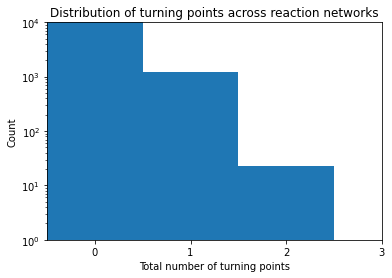

In [109]:
tpl = np.array(turning_points_list, dtype=int).flatten().flatten()

plt.figure()
bmin = 0
bmax = 2
bins = np.arange(-0.5, 3.5)  # Shift bins so centers are at integer values
plt.hist(tpl, bins=bins, align='mid')
plt.xlabel('Total number of turning points')
plt.ylabel('Count')
plt.yscale('log')
plt.ylim(1,1e4)
plt.xlim(bmin-0.5,bmax-0.5)
plt.xticks(range(bmin,bmax+2))
plt.title('Distribution of turning points across reaction networks')

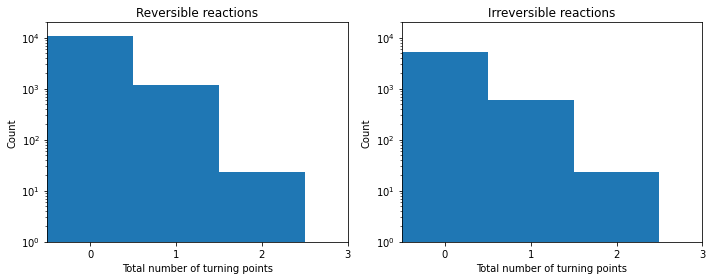

In [115]:
path1 = '/Users/csfloyd/Dropbox/Projects/GlycanAnalysis/PythonOutput/Rev_SO_1sparseconstr.apkl'
path2 = '/Users/csfloyd/Dropbox/Projects/GlycanAnalysis/PythonOutput/Irr_SO_1sparseconstr.apkl'

paths = [path1, path2]
titles = ['Reversible', 'Irreversible']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), facecolor='white')
bmin, bmax = 0, 2
bins = np.arange(-0.5, 3.5)

for path, title, ax in zip(paths, titles, [ax1, ax2]):
    data = import_data_from_apkl(path)
    ss_response_list = data['ss_response_list']
    turning_points_list = recompute_turning_points_list(ss_response_list, eps=1e-3, smooth=True, window_length=5, polyorder=1, prominence=1e-3, wlen=5)
    
    tpl = np.array(turning_points_list, dtype=int).flatten().flatten()
    ax.hist(tpl, bins=bins, align='mid')
    ax.set_xlabel('Total number of turning points')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    ax.set_ylim(1, 2e4)
    ax.set_xlim(bmin-0.5, bmax-0.5)
    ax.set_xticks(range(bmin, bmax+2))
    ax.set_title(f'{title} reactions')


plt.tight_layout()
plt.savefig('/Users/csfloyd/Dropbox/Projects/GlycanAnalysis/Figures/RevIrrevTurningPointsSO.png', dpi=300)


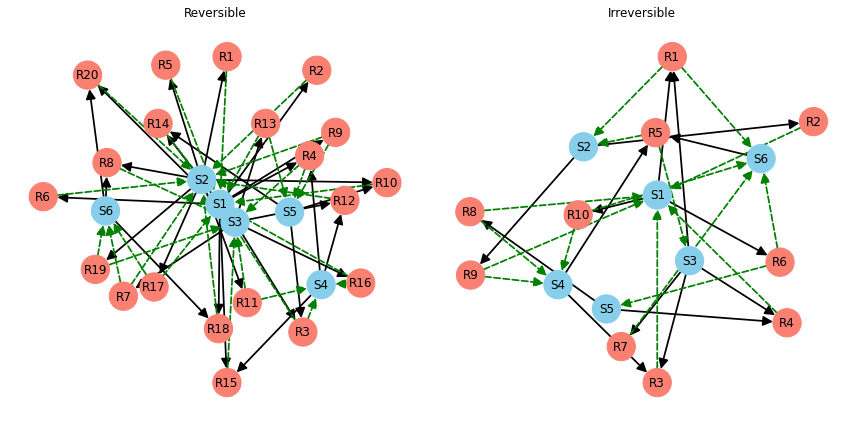

In [114]:
path1 = '/Users/csfloyd/Dropbox/Projects/GlycanAnalysis/PythonOutput/Rev_SO_1sparseconstr.apkl'
path2 = '/Users/csfloyd/Dropbox/Projects/GlycanAnalysis/PythonOutput/Irr_SO_1sparseconstr.apkl'

paths = [path1, path2]
titles = ['Reversible', 'Irreversible']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')
bmin, bmax = 0, 1
bins = np.arange(-0.5, 3.5)
ax1.set_title('Reversible')
ax2.set_title('Irreversible')

for path, title, ax in zip(paths, titles, [ax1, ax2]):
    data = import_data_from_apkl(path)
    G_list = data['G_list']
    G = G_list[3]
    draw_bipartite_reaction_network(G, ax=ax)

plt.tight_layout()
plt.savefig('/Users/csfloyd/Dropbox/Projects/GlycanAnalysis/Figures/RevIrrevReactionGraphsSO.png', dpi=300)

[7.0, 7.0, 7.0, 5.0, 19.0, 13.0, 13.0, 14.0, 5.0, 15.0, 13.0, 5.0, 22.0, 14.0, 8.0, 24.0, 10.0, 12.0, 7.0, 17.0, 15.0, 24.0, 14.0, 8.0, 9.0, 19.0, 14.0, 8.0, 7.0, 13.0, 5.0, 20.0, 11.0, 20.0, 7.0, 5.0, 3.0, 10.0, 13.0, 14.0, 15.0, 25.0, 8.0, 6.0, 4.0, 12.0, 5.0, 15.0, 9.0, 17.0, 22.0, 13.0, 17.0, 25.0, 9.0, 13.0, 12.0, 10.0, 21.0, 21.0, 14.0, 15.0, 17.0, 11.0, 9.0, 10.0, 13.0, 14.0, 6.0, 5.0, 11.0, 10.0, 11.0, 6.0, 13.0, 21.0, 16.0, 4.0, 20.0, 12.0, 14.0, 13.0, 10.0, 13.0, 16.0, 1.0, 14.0, 5.0, 5.0, 15.0, 19.0, 15.0, 10.0, 17.0, 16.0, 18.0, 11.0, 15.0, 16.0, 12.0]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 2. 0. 0. 1.]]
[26]
[]


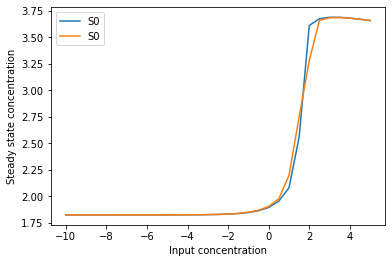

In [113]:
from scipy.signal import find_peaks

sum_over_trials = [sum(sum(turning_points)) for turning_points in turning_points_list]
max_over_trials = [np.max(np.max(turning_points)) for turning_points in turning_points_list]
print(sum_over_trials)
trial_ind = np.argmax(max_over_trials)
#trial_ind = 33
print(np.array(turning_points_list[trial_ind]))

input_vals = np.linspace(-10, 5, 31)  # range of input values to scan

# ## --- Plot steady-state response curves ---
# ss_ind = 4
# for i in range(ss_responses[ss_ind].shape[1]):
#     plt.plot(input_vals, ss_responses[ss_ind][:, i], label=f'S{i+1}')


ss_ind = -1
k_ind = -1
y = ss_response_list[trial_ind][ss_ind][:, k_ind]
prom = 1e-3
wlen = 5
peaks, _ = find_peaks(y, prominence=prom, wlen = wlen)
valleys, _ = find_peaks(-y, prominence=prom, wlen = wlen)
print(peaks)
print(valleys)
plt.plot(input_vals, y, label=f'S{k_ind+1}')

y_smooth = smooth_curve(y)
print(count_turning_points(y_smooth, eps=1e-3))
plt.plot(input_vals, y_smooth, label=f'S{k_ind+1}')

plt.xlabel('Input concentration')
plt.ylabel('Steady state concentration')
plt.legend()

In [ ]:
G = reaction_network_to_bipartite_graph(reaction_network, n_species)
#top = nx.bipartite.sets(G)[0]


# Create color map after graph is created
color_map = []
for node in G.nodes():
    if node.startswith('S'):  # Species nodes
        color_map.append('skyblue')
    else:  # Reaction nodes
        color_map.append('salmon')

edge_colors = []
edge_widths = []
edge_styles = []
for u, v in G.edges():
    if u.startswith('S') and v.startswith('R'):
        edge_colors.append('black')
        edge_widths.append(1.75)
        edge_styles.append('solid')
    elif u.startswith('R') and v.startswith('S'):
        edge_colors.append('green')
        edge_widths.append(1.75)
        edge_styles.append('dashed')

#pos = nx.bipartite_layout(G, top)
pos = nx.spring_layout(G)
#pos = nx.spiral_layout(G)

# Note: nx.draw does not support per-edge style directly, but you can use nx.draw_networkx_edges for more control:
plt.figure(figsize=(10, 6))

nx.draw(
    G, pos,
    with_labels=True,
    node_color=color_map,
    edge_color=edge_colors,
    width=edge_widths,
    style=edge_styles,
    node_size=800,
    arrows=True,
    arrowsize=20  # <-- Increase this value for larger arrows (default is 10)
)
plt.show()